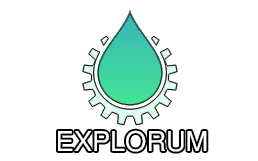

# -------------------------------------------------------------------------------------------
#### - Saleh Atwah
#### - Obai Shaikh



### <a>1.1. Background</a>
Well logs are interpreted/processed to estimate the in-situ petrophysical and geomechanical properties, which is essential for subsurface characterization. Various types of logs exist, and each provides distinct information about subsurface properties. Certain well logs, like gamma ray (GR), resistivity, density, and neutron logs, are considered as “easy-to-acquire” conventional well logs that are run in most of the wells. Other well logs, like nuclear magnetic resonance, dielectric dispersion, elemental spectroscopy, and sometimes sonic logs, are only run in limited number of wells.

Sonic travel-time logs contain critical geomechanical information for subsurface characterization around the wellbore. Often, sonic logs are required to complete the well-seismic tie workflow or geomechanical properties prediction. When sonic logs are absent in a well or an interval, a common practice is to synthesize them based on its neighboring wells that have sonic logs. This is referred to as sonic log synthesis or pseudo sonic log generation.


### <a>1.2. Problem Statement</a>
Compressional travel-time (DTC) and shear travel-time (DTS) logs are not acquired in all the wells drilled in a field due to financial or operational constraints. Under such circumstances, machine learning techniques can be used to predict DTC and DTS logs to improve subsurface characterization. The goal of the “SPWLA’s 1st Petrophysical Data-Driven Analytics Contest” is to develop data-driven models by processing “easy-to-acquire” conventional logs from Well #1, and use the data-driven models to generate synthetic compressional and shear travel-time logs (DTC and DTS, respectively) in Well #2. A robust data-driven model for the desired sonic-log synthesis will result in low prediction errors, which can be quantified in terms of Root Mean Squared Error by comparing the synthesized and the original DTC and DTS logs.

You are provided with two datasets: train.csv and test.csv. You need to build a generalizable data-driven models using train dataset. Following that, you will deploy the newly developed data-driven models on test dataset to predict DTS and DTC logs. The data-driven model should use feature sets derived from the following 7 logs: Caliper, Neutron, Gamma Ray, Deep Resistivity, Medium Resistivity, Photo-electric factor and density. The data-driven model should synthesize two target logs: DTC and DTS logs.

The predicted values should be in the same format as sample_submission.csv, and submit together with your notebook for evaluation. 

### <a>1.3. Data Decription</a>
#### Files
&gt; #### train.csv
All the values equals to -999 are marked as missing values.
- CAL - Caliper, unit in Inch,  
- CNC - Neutron, unit in dec 
- GR - Gamma Ray, unit in API
- HRD - Deep Resisitivity, unit in Ohm per meter,
- HRM - Medium Resistivity, unit in Ohm per meter,
- PE - Photo-electric Factor, unit in Barn,
- ZDEN - Density, unit in Gram per cubit meter, 
- DTC - Compressional Travel-time, unit in nanosecond per foot,
- DTS - Shear Travel-time, unit in nanosecond per foot,


&gt; #### test.csv
The test data has all features that you used in the train dataset, except the two sonic curves DTC and DTS.

&gt; ####   real_result_20perc.csv
20% randomly sampled from orginal data.


&gt; ####  sample_submission.csv
A valid sample submission.
<p><font style="">
</font></p>

### <a>1.4. Evaluation Metric</a>
We will be evaluated by the metirc `Root Mean Squared Error`.

The RMSE is calculated as:

$ ϵ=∑_i \sqrt{ ∑_n (y_p - y_t)^2 /n } $

Where:
- y_p is the predicted curve for DTC and DTS
- y_t is the true value for evaluation.

DTC and DTS are in the same weight during the evaluation 

Understanding and optimizing your predictions for this evaluation metric is paramount for this compeition.

## <a>2a. Imports</a>

In [159]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFwe, VarianceThreshold, f_regression, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import ElasticNetCV
# !jupyter nbextension enable --py widgetsnbextension
# #you are my saver!
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
# # import libraries
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
# import sklearn libararies
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer , KNNImputer


## <a>2b. define functions</a>

In [4]:
def result_plot(y_predict, y_real):
    # check the accuracy of predicted data and plot the result
    print('Root Mean Square Error is:', '{:.5f}'.format(np.sqrt(mean_squared_error(y_real, y_predict))))
    plt.subplots(nrows=2, ncols=2, figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(y_real[:, 0])
    plt.plot(y_predict[:, 0])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTC')
    plt.title('DTC Prediction Comparison')

    plt.subplot(2, 2, 2)
    plt.plot(y_real[:, 1])
    plt.plot(y_predict[:, 1])
    plt.legend(['True', 'Predicted'])
    plt.xlabel('Sample')
    plt.ylabel('DTS')
    plt.title('DTS Prediction Comparison')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_real[:, 0], y_predict[:, 0])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTC Prediction Comparison')
    
    plt.subplot(2, 2, 4)
    plt.scatter(y_real[:, 1], y_predict[:, 1])
    plt.xlabel('Real Value')
    plt.ylabel('Predicted Value')
    plt.title('DTS Prediction Comparison')

    plt.show()

In [230]:
def log_plot(logs):
    #sort dta by depth
    logs = logs.sort_values(by='Depth')
   
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    logs.HRD=np.log10(logs.HRD)
    logs.HRM=np.log10(logs.HRM)
    
    f, ax = plt.subplots(nrows=1, ncols=9, figsize=(17, 10))
    ax[0].plot(logs.CAL, logs.Depth, '-g')
    ax[1].plot(logs.CNC, logs.Depth, '-')
    ax[2].plot(logs.GR, logs.Depth, '-', color='0.5')
    ax[3].plot(logs.HRD, logs.Depth, '-', color='r')
    ax[4].plot(logs.HRM, logs.Depth, '-', color='black')
    ax[5].plot(logs.PE, logs.Depth, '-g')
    ax[6].plot(logs.ZDEN, logs.Depth, '-')
    ax[7].plot(logs.DTC, logs.Depth, '-', color='0.5')
    ax[8].plot(logs.DTS, logs.Depth, '-', color='r')
    
    for i in range(len(ax)):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=10)
    
    ax[0].set_xlabel("CAL")
    ax[0].set_xlim(logs.CAL.min(),logs.CAL.max())
    ax[1].set_xlabel("CNC")
    ax[1].set_xlim(logs.CNC.min(),0.5)
    ax[2].set_xlabel("GR")
    ax[2].set_xlim(logs.GR.min(),logs.GR.max())
    ax[3].set_xlabel("log10HRD")
    ax[3].set_xlim(logs.HRD.min(),logs.HRD.max())
    ax[4].set_xlabel("log10HRM")
    ax[4].set_xlim(logs.HRM.min(),logs.HRM.max())
    ax[5].set_xlabel("PE")
    ax[5].set_xlim(logs.PE.min(),logs.PE.max())
    ax[6].set_xlabel("ZDEN")
    ax[6].set_xlim(logs.ZDEN.min(),logs.ZDEN.max())
    ax[7].set_xlabel("DTC")
    ax[7].set_xlim(logs.DTC.min(),logs.DTC.max())
    ax[8].set_xlabel("DTS")
    ax[8].set_xlim(logs.DTS.min(),logs.DTS.max())
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[7].set_yticklabels([]); ax[8].set_yticklabels([])

    
    plt.show()

## <a>3. work / data science</a>

In [6]:
# loading data
data = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [7]:
test.shape

(11088, 7)

In [8]:
data['Depth']=data.index

In [9]:
# # remove all rows that contains missing value
data.replace(['-999', -999], np.nan, inplace=True)
# data.dropna(axis=0, inplace=True)

data.replace(['-999', -999], np.nan, inplace=True)
# data.dropna(axis=0, inplace=True)

features=['CAL', 'CNC', 'GR', 'HRD', 'HRM', 'PE', 'ZDEN']
target = ['DTC','DTS']

In [10]:
data.head(5)


CAL  CNC       GR  HRD  HRM  PE  ZDEN       DTC       DTS  Depth
0  NaN  NaN  41.4699  NaN  NaN NaN   NaN  128.0737  319.0654      0
1  NaN  NaN  42.5053  NaN  NaN NaN   NaN  127.8347  318.7825      1
2  NaN  NaN  43.1548  NaN  NaN NaN   NaN  127.2307  317.3323      2
3  NaN  NaN  43.2410  NaN  NaN NaN   NaN  126.2917  313.6486      3
4  NaN  NaN  40.3218  NaN  NaN NaN   NaN  125.3985  307.8903      4

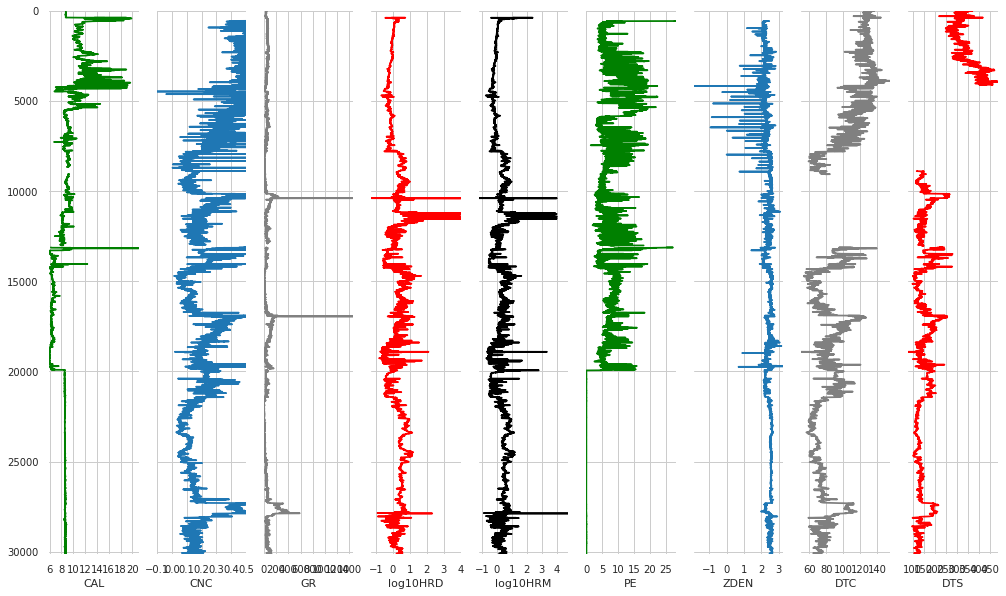

In [231]:
log_plot(data)

## NOTE!
we noticed that PE is less than 0.5 twoard the end of the data , this doesnt make sense , there's no such masurement as stable! , masurements represent change therfore must be represented by a changing signal

In [15]:
#fix pe in that lower section

In [12]:
data_imp=data.copy()

In [13]:
data_imp['PE'][data_imp['PE']<0.5]=0
data_imp.replace([0], np.nan, inplace=True)

/rcd/ircc/geolog/atwahsz/mldl/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


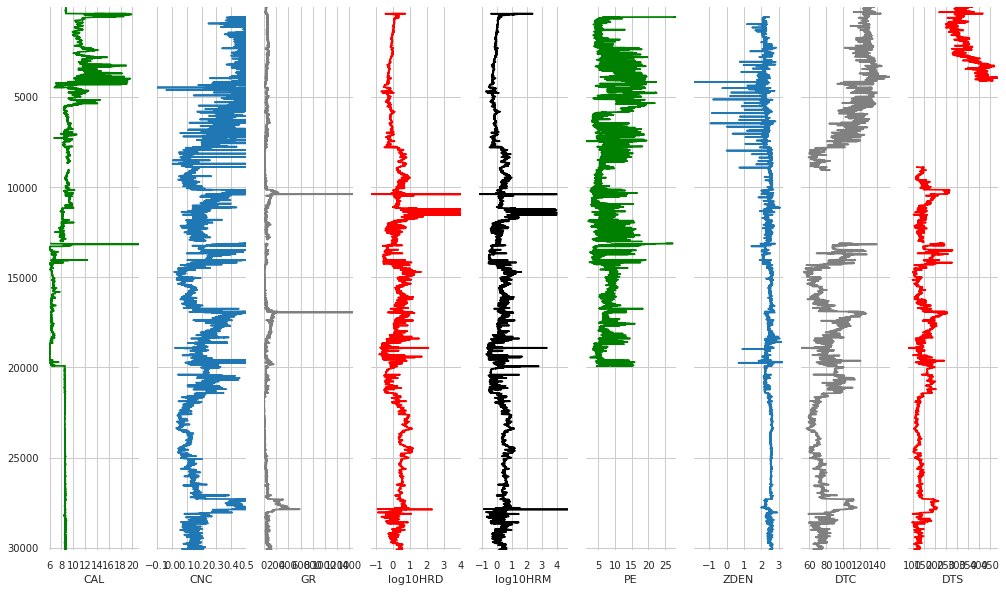

In [232]:
log_plot(data_imp)

In [15]:
DTC_data=data_imp.drop(columns=['Depth','DTS']).dropna().reset_index()

/rcd/ircc/geolog/atwahsz/mldl/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
/rcd/ircc/geolog/atwahsz/mldl/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.


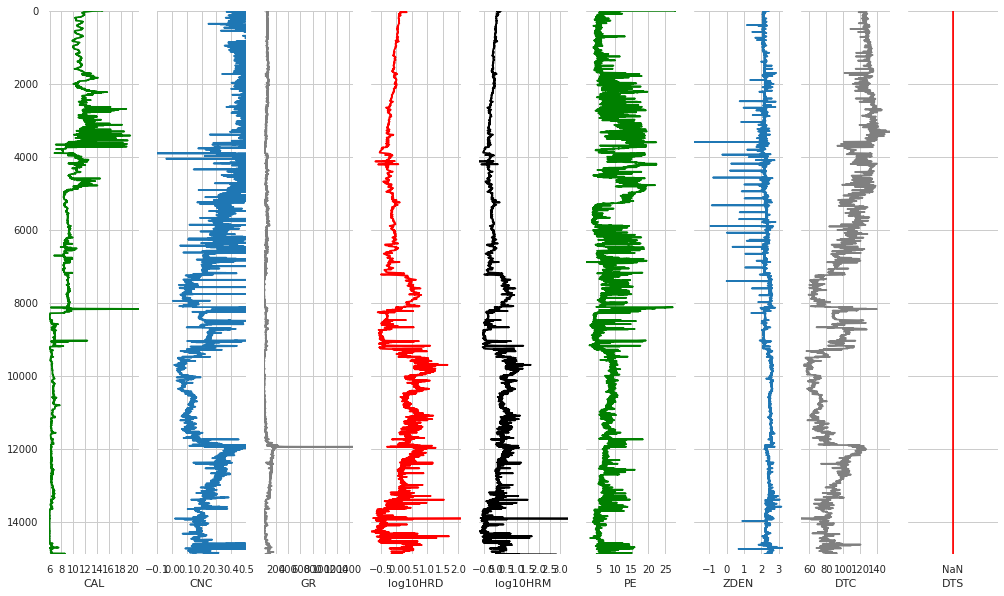

In [233]:
DTC_data['DTS']='NaN'
DTC_data['Depth']=DTC_data.index
log_plot(DTC_data)

In [17]:
DTS_data=data_imp.drop(columns=['Depth','DTC']).dropna().reset_index()

/rcd/ircc/geolog/atwahsz/mldl/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
/rcd/ircc/geolog/atwahsz/mldl/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Attempting to set identical left == right == [0.] results in singular transformations; automatically expanding.


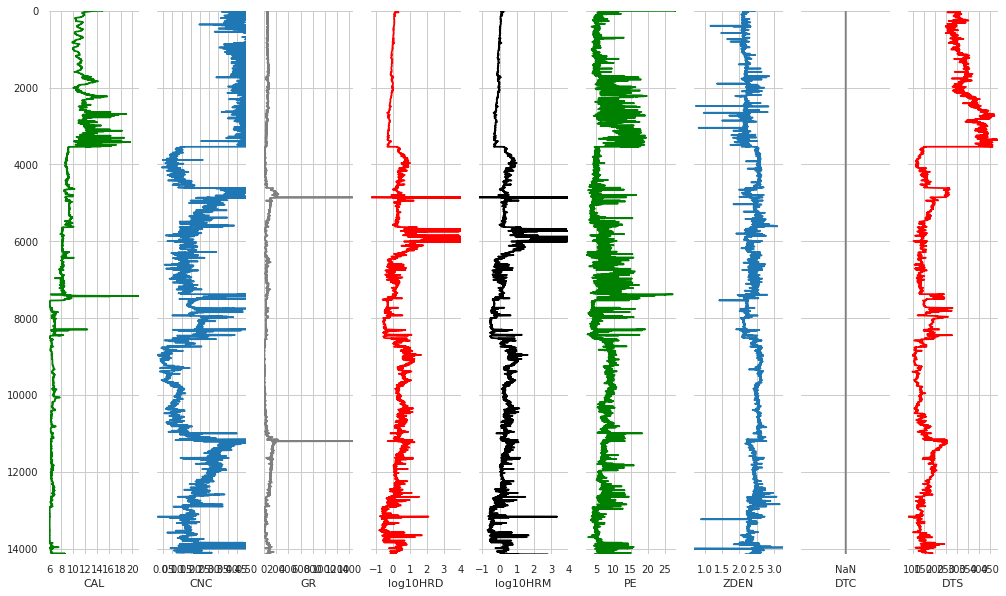

In [234]:
DTS_data['DTC']='NaN'
DTS_data['Depth']=DTS_data.index
log_plot(DTS_data)

In [155]:
train_dtc_=DTC_data[features].to_numpy()
train_dts_=DTS_data[features].to_numpy()
scaler2 = MinMaxScaler().fit(train_dts_)
X_DTS_train_sca2 = scaler.transform(train_dts_)

In [45]:
X_DTC_train, X_DTC_test, y_DTC_train, y_DTC_test = train_test_split(train_dtc_, DTC_data.DTC, test_size=0.3, random_state=100)
X_DTS_train, X_DTS_test, y_DTS_train, y_DTS_test = train_test_split(train_dts_, DTS_data.DTS,test_size=0.3, random_state=100)

In [46]:
    y_DTC_train = np.array(y_DTC_train).ravel()
    y_DTC_test = np.array(y_DTC_test).ravel()

    
    # Scale training sets
    scaler = StandardScaler().fit(X_DTC_train)
    X_DTC_train_sca = scaler.transform(X_DTC_train)

    # Scale testing sets
    X_DTC_test_sca = StandardScaler().fit_transform(X_DTC_test)

In [145]:
    y_DTS_train = np.array(y_DTS_train).ravel()
    y_DTS_test = np.array(y_DTS_test).ravel()

    
    # Scale training sets
    scaler = StandardScaler().fit(X_DTS_train)
    X_DTS_train_sca = scaler.transform(X_DTS_train)

    # Scale testing sets
    X_DTS_test_sca = StandardScaler().fit_transform(X_DTS_test)

In [ ]:
from tpot import TPOTRegressor
DTC_search_op = TPOTRegressor(verbosity=2, scoring='r2', cv=10, n_jobs=55, 
                      generations=100, config_dict='TPOT sparse',
                      population_size=100, random_state=100,
                      early_stop = 75)


In [ ]:
DTC_search_op.fit(X_DTC_train,y_DTC_train)

In [ ]:
DTC_search_op.export('DTC_search_op_28april.py')

In [ ]:
from tpot import TPOTRegressor
DTS_search_op = TPOTRegressor(verbosity=2, scoring='r2', cv=10, n_jobs=55, 
                      generations=100, config_dict='TPOT sparse',
                      population_size=5, random_state=100,
                      early_stop = 25)

In [ ]:
DTS_search_op.fit(X_DTS_train,y_DTS_train)

In [ ]:
DTC_search_op.export('DTS_search_op_28april.py')

In [209]:
DTC_model= make_pipeline(
    StackingEstimator(estimator=LinearSVR(C=0.001, dual=False, epsilon=0.01, loss="squared_epsilon_insensitive", tol=0.01)),
    StackingEstimator(estimator=ElasticNetCV(l1_ratio=0.6000000000000001, tol=0.1)),
    RandomForestRegressor(bootstrap=False, max_features=0.35000000000000003, min_samples_leaf=1, min_samples_split=2, n_estimators=100)
)
set_param_recursive(DTS_model.steps, 'random_state', 77)

In [210]:

DTS_model = make_pipeline(
    StackingEstimator(estimator=RandomForestRegressor(bootstrap=True, max_features=0.8500000000000001, min_samples_leaf=2, min_samples_split=3, n_estimators=100)),
    RidgeCV()
)
# # Fix random state for all the steps in exported pipeline
set_param_recursive(DTS_model.steps, 'random_state', 77)

In [211]:
DTC_model.fit(train_dtc_, DTC_data.DTC)

Pipeline(memory=None,
         steps=[('stackingestimator-1',
                 StackingEstimator(estimator=LinearSVR(C=0.001, dual=False,
                                                       epsilon=0.01,
                                                       fit_intercept=True,
                                                       intercept_scaling=1.0,
                                                       loss='squared_epsilon_insensitive',
                                                       max_iter=1000,
                                                       random_state=None,
                                                       tol=0.01, verbose=0))),
                ('stackingestimator-2',
                 StackingEstimator(estimator=ElasticNetCV(alphas=None,
                                                          copy_X=True, cv=None,
                                                          eps...
                 RandomForestRegressor(bootstrap=False, ccp_alpha=0.0,

In [212]:
DTS_model.fit(train_dts_, DTS_data.DTS)

Pipeline(memory=None,
         steps=[('stackingestimator',
                 StackingEstimator(estimator=RandomForestRegressor(bootstrap=True,
                                                                   ccp_alpha=0.0,
                                                                   criterion='mse',
                                                                   max_depth=None,
                                                                   max_features=0.8500000000000001,
                                                                   max_leaf_nodes=None,
                                                                   max_samples=None,
                                                                   min_impurity_decrease=0.0,
                                                                   min_impurity_split=None,
                                                                   min_samples_leaf=2,
                                                              

In [225]:
df_testing=pd.read_csv('real_result_20perc.csv')


In [226]:
X_test = df_testing[features].values
y_test = df_testing[target].values

In [227]:
# X_test_sca = MinMaxScaler().fit_transform(X_test)

In [228]:
DTC_results = DTC_model .predict(X_test)
DTS_results = DTS_model .predict(X_test)

Root Mean Square Error is: 17.27605


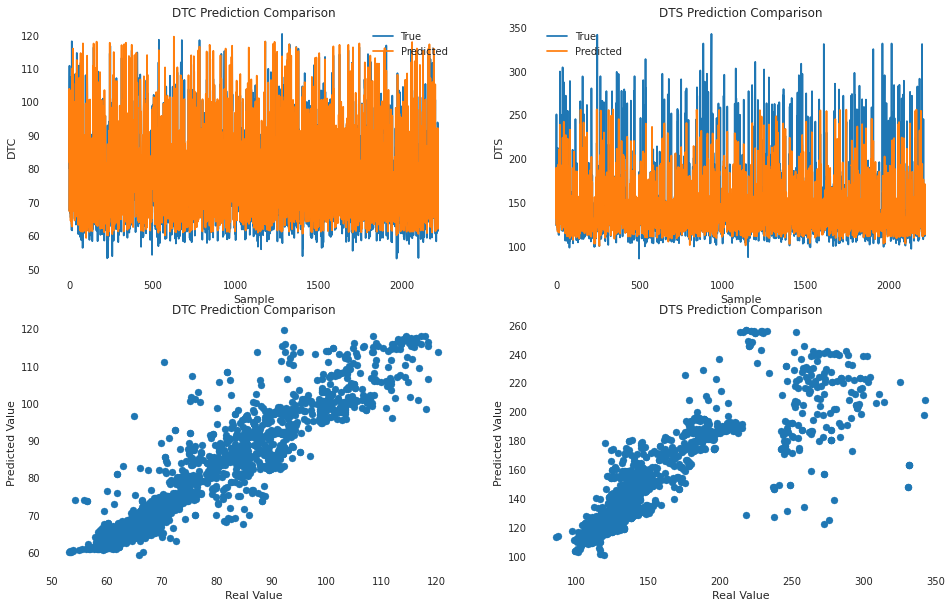

In [229]:
output_result20 = (pd.DataFrame({'DTC':DTC_results, 'DTS':DTS_results}, columns=['DTC','DTS'])).to_numpy()
y_test=df_testing[target].values
result_plot(output_result20, y_test)

In [218]:
test.head()

CAL     CNC       GR     HRD     HRM      PE    ZDEN         DTC  \
0  8.5781  0.3521  55.1824  0.8121  0.7810  6.8291  2.3256  108.741782   
1  8.5781  0.3639  57.0114  0.8038  0.7723  6.8100  2.3255  109.679344   
2  8.5781  0.3703  58.9263  0.7444  0.7048  6.7766  2.3212  112.932144   
3  8.5625  0.3667  57.3308  0.7169  0.6542  6.7219  2.3119  110.123164   
4  8.5781  0.3500  53.0624  0.6845  0.6109  6.6384  2.2982  105.919737   

          DTS  Depth  
0  213.002033      0  
1  214.417249      1  
2  215.566402      2  
3  219.568387      3  
4  226.087510      4

In [219]:
X_test_sub = test[features].values


In [220]:
DTC_results_sub = DTC_model .predict(X_test_sub)
DTS_results_sub = DTS_model .predict(X_test_sub)

In [221]:
test['DTC']=DTC_results_sub
test['DTS']=DTS_results_sub
test['Depth']=test.index

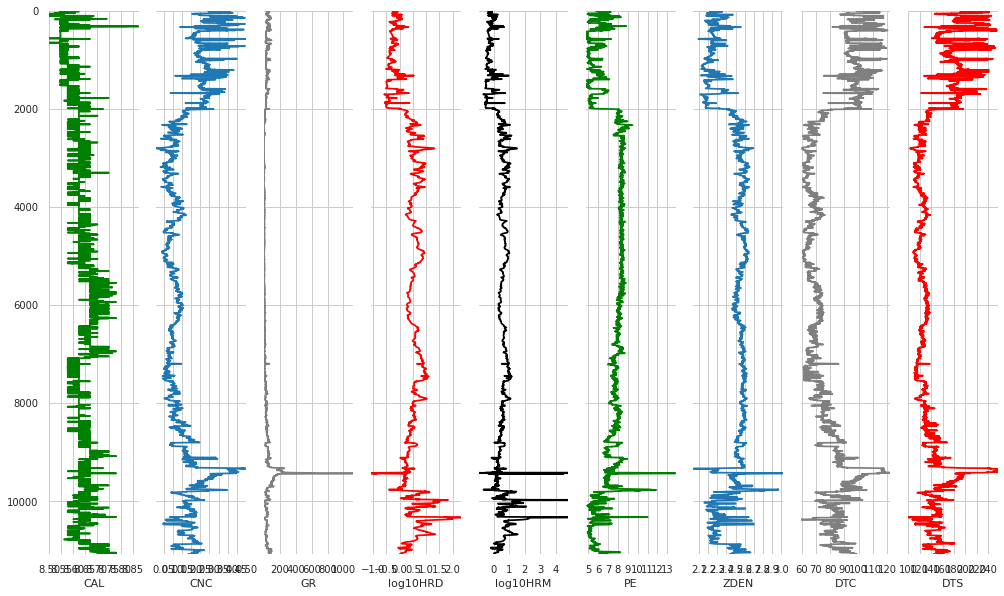

In [235]:
log_plot(test)

In [223]:
final_results= (pd.DataFrame({'DTC':DTC_results_sub, 'DTS':DTS_results_sub}, columns=['DTC','DTS']))

In [224]:
final_results.to_csv('Explorum_submission_2.csv',index=False)